## Hubert Prediction

A notebook to explore using Hubert. Based partially off of our work on Perceptual Qualities (https://arxiv.org/abs/2310.02497)

In [99]:
import os
import sys
# Leave the line below uncommented if you have a CUDA device or multiple
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("../")

import torch
import torchaudio

import IPython
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import *

# Importing Sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import time


In [2]:
print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu118
2.1.0+cu118


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
bundle = torchaudio.pipelines.HUBERT_BASE
# bundle = torchaudio.pipelines.HUBERT_XLARGE


print("Sample Rate:", bundle.sample_rate)

Sample Rate: 16000


In [6]:
model = bundle.get_model().to(device)

In [7]:
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [8]:
# Let's Load in a Specific File
SPEECH_FILE = "../data/pvqd/audio_clips/BL10_ENSS.wav"
IPython.display.Audio(SPEECH_FILE)

In [9]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

/home/robbizorg/miniconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:1464: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  resampled = torch.nn.functional.conv1d(waveform[:, None], kernel, stride=orig_freq)


In [10]:
with torch.inference_mode():
    features = model.extract_features(waveform)
    features = features[0]

In [47]:
# fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
# for i, feats in enumerate(features):
#     ax[i].imshow(feats[0].cpu(), interpolation="nearest")
#     ax[i].set_title(f"Feature from transformer layer {i+1}")
#     ax[i].set_xlabel("Feature dimension")
#     ax[i].set_ylabel("Frame (time-axis)")
    
# fig.tight_layout()

In [11]:
# Dimension is BxTxD 
sixth_layer = features[5]
sixth_layer.shape

torch.Size([1, 1936, 768])

## Let's Use HuBERT for Some Prediction

In [12]:
## Load in the DataFrame
y_train = pd.read_csv('../data/pvqd/train_test_split/y_train.csv', index_col=0)
y_val = pd.read_csv('../data/pvqd/train_test_split/y_val.csv', index_col=0)

# Load in the Test Set below if you want it

y_train.head()

File  Breathiness   Loudness      Pitch  Roughness     Strain
0  LA7005     7.000000   7.333333   7.000000   8.500000   8.000000
1   PT116    31.833333  12.333333   6.000000  29.500000   7.333333
2   PT034    43.166667  26.666667  61.166667  34.000000  30.333333
3  SJ6006     4.375000   5.125000   0.250000   3.750000   6.875000
4   PT005     5.500000   7.000000  12.000000   3.833333   4.500000

We want to predict the five perceptual qualities: Breathiness, Loudness, Pitch, Roughness, and Strain. First, we have to link the files with their labels. 

In [37]:
# Linking the `File` column with the actual File Name
# NOTE: This code is inefficient--why is it inefficient and how can we make it faster?

data_path = "../data/pvqd/audio_clips/"
audio_files = os.listdir(data_path)
speaker_ids = [extract_speaker(audio_file) for audio_file in audio_files]

# Assertion to make sure speaker_ids matches y_train['File']
i = 0
for spk_id in y_train["File"]:
    try:
        assert spk_id in speaker_ids
    except:
        print(spk_id)
        i+=1

# Dictionary to Link Speaker ID to Audio File for O(1) access
speaker_file_dict = {}
for i in range(0, len(speaker_ids)):
    speaker_file_dict[speaker_ids[i]] = os.path.join(data_path, audio_files[i])

### What model and features should we use?

As we saw earlier, there's a lot of layers in HuBERT, and each one contains different information (https://arxiv.org/pdf/2211.03929.pdf). The choice between layer 3 or layer 8 could result in vastly different predictive performance. Then there's the question of how we should even process the features! Should we use the raw shape of Batch-Size x Time-Dim x Feature Dim, or should we do some aggregation and perform a simple linear regression on top of that?

When it comes to machine learning and modeling, there's no reason not to try them all if you have the time (provided you've done the proper train-validation-test split first!). If you don't have the time, you have to use your best judgement to decide which archietctures, objective functions, and feature representations to explore first. This intuition comes with time.

To start off with, let's use Scikit-Learn (https://scikit-learn.org/stable/) to run some simple regression models (Linear, Lasso, and Random Forest) on a naive averaged version of the sixth HuBERT layer. 

In [49]:
# Process the features and turn it into a dataframe
# NOTE: Is this the most efficient way to do this? How can we refactor this code? Should we be storing all this data in memory?

X_train = []
X_val = []

# Construct X_train
start_time = time.time() # Let's do some simple profiling
for spk_id in y_train["File"]:
    audio_file = speaker_file_dict[spk_id]

    # Load in the Audio and 
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    # Extract the HuBERT layers like before
    with torch.inference_mode():
        features = model.extract_features(waveform)
        features = features[0]

    sixth_layer = features[5]

    # TODO: Take the the mean over the Time dimension
    # Link: https://pytorch.org/docs/stable/generated/torch.mean.html 

    sixth_layer_mean = sixth_layer.mean(dim=1)

    # Scikit learn doesn't work with Tensors, so we load them onto the CPU 
    # and convert to Numpy
    features = sixth_layer_mean[0].cpu().numpy() 
    X_train.append(features)

X_train = np.array(X_train)
elapsed_time = time.time() - start_time
print("Finished building X_train in %s seconds" % round(elapsed_time, 2))

# Construct X_val
start_time = time.time() # Let's do some simple profiling
for spk_id in y_val["File"]:
    audio_file = speaker_file_dict[spk_id]

    # Load in the Audio and 
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    # Extract the HuBERT layers like before
    with torch.inference_mode():
        features = model.extract_features(waveform)
        features = features[0]

    sixth_layer = features[5]

    # TODO: Take the the mean over the Time dimension
    # Link: https://pytorch.org/docs/stable/generated/torch.mean.html 

    sixth_layer_mean = sixth_layer.mean(dim=1)

    # Scikit learn doesn't work with Tensors, so we load them onto the CPU 
    # and convert to Numpy
    features = sixth_layer_mean[0].cpu().numpy() 
    X_val.append(features)

X_val = np.array(X_val)
elapsed_time = time.time() - start_time
print("Finished building X_val in %s seconds" % round(elapsed_time, 2))


Finished building X_train in 12.1 seconds
Finished building X_val in 1.92 seconds


### Let's train some models!

Sanity Check: Are you absolutely certain that the first row of X_train is associated with the first row of y_train?

Below, we're going to train a linear and lasso regression model. How do you think it will do? 

In [55]:
## TODO: Follow the documentation from sklearn.linear_model.Linear_Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 
## to train a Linear and Lasso Regression
np.random.seed(42) # Set the seed so that we all get the same results--hopefully

# TODO: Create and train a Linear Regression Model called reg
# reg = ???
reg = LinearRegression().fit(X_train, y_train.drop(["File"], axis=1))

In [64]:
# TODO: Use Reg to Predict X_train and evaluate

preds = reg.predict(X_val)
assert preds.shape == y_val.drop(["File"], axis=1).shape # Sanity check assertion

# Calculate the Mean Squared Error--Wait, is this right?
rmse = mean_squared_error(y_val.drop(["File"], axis=1).values, preds, squared=False)
print("Linear Model RMSE %s" % rmse)

Linear Model RMSE 12.632025976193457


In [70]:
## TODO: Calculate the RMSE Column-wise
y_values = y_val.drop(["File"], axis=1).values

np.sqrt(np.mean((preds - y_values)**2, axis = 0))

array([12.75831236, 10.17875071, 12.23739225, 16.31510453, 11.67057003])

### Let's now train a Lasso

Some question: What's a lasso regression? Why would we want to try a lasso regression?

In [72]:
# TODO: Create and train a Lasso Regression Model called lasso_reg with alpha = 0.1
# lasso_reg = ???
lasso_reg = Lasso(alpha=0.1).fit(X_train, y_train.drop(["File"], axis=1))

In [81]:
# TODO: Use lasso_reg to Predict X_train and evaluate

lasso_preds = lasso_reg.predict(X_val)
assert lasso_preds.shape == y_val.drop(["File"], axis=1).shape # Sanity check assertion

# Calculate the Mean Squared Error--Wait, is this right?
rmse = mean_squared_error(y_val.drop(["File"], axis=1).values, lasso_preds, squared=False)
print("Lasso Model RMSE %s" % rmse)

Lasso Model RMSE 13.650276167382865


In [75]:
## TODO: Calculate the RMSE Column-wise
y_values = y_val.drop(["File"], axis=1).values

np.sqrt(np.mean((lasso_preds - y_values)**2, axis = 0))

array([11.71735088, 13.32189362, 14.02628183, 16.54671589, 12.63913862])

### Questions

How does linear regression vs. lasso regression perform, based on RMSE?

### Let's Try Random Forest Regression

Linear models are nice and all, but they're just that--linear. Speech is an incredibly complex phenomena that can't possibly represented by linear relationships (right?). Let's see how linear models compare against [random forests](https://en.wikipedia.org/wiki/Random_forest), a common ensemble method that is particularly handy at characterizing non-linear relationships.  

In [78]:
# TODO: Train a random forest model using [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
# Have you noticed a pattern with Sklearn yet?


start_time = time.time()
# rf_reg = ???
rf_reg = RandomForestRegressor().fit(X_train, y_train.drop(["File"], axis=1))
end_time = time.time()
print("Finished Training RF in %s Seconds" % (end_time- start_time))

Finished Training RF in 8.161197185516357 Seconds


In [80]:
# TODO: Use rf_reg to Predict X_train and evaluate

rf_preds = rf_reg.predict(X_val)
assert rf_preds.shape == y_val.drop(["File"], axis=1).shape # Sanity check assertion

# Calculate the Mean Squared Error--Wait, is this right?
rmse = mean_squared_error(y_val.drop(["File"], axis=1).values, rf_preds, squared=False)
print("Random Forest Model RMSE %s" % rmse)

Random Forest Model RMSE 12.84886760621038


In [82]:
## TODO: Calculate the RMSE Column-wise
y_values = y_val.drop(["File"], axis=1).values

np.sqrt(np.mean((rf_preds - y_values)**2, axis = 0))

array([10.57892044, 11.5241484 , 12.27187104, 15.91379721, 13.95560095])

### Takeaways and Discussion

So, which model performed the best? Can you tell? How might you further investigate to further guarantee that one model performs better than another? (Hint: Look into bootstrapping)

What happens if you vary all the different models we chose? Different hyperparameters, different aggregation (why just do the mean?), different layers, a different representation altogether?

In a lot of Machine Learning problems, not just in Speech, there are decisions after decisions to be made and varied. 

## One Such Exploration: What happens if we vary the layer we examine?

In [95]:
# Process the features and turn it into a dataframe
# NOTE: Is this the most efficient way to do this? How can we refactor this code? Should we be storing all this data in memory?

X_trains = []
X_vals = []

# Construct X_train
start_time = time.time() # Let's do some simple profiling
for spk_id in y_train["File"]:
    audio_file = speaker_file_dict[spk_id]

    # Load in the Audio and 
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    # Extract the HuBERT layers like before
    with torch.inference_mode():
        features = model.extract_features(waveform)
        features = features[0]

    all_layer_means = [layer.mean(dim=1)[0].cpu().numpy() for layer in features]

    X_trains.append(all_layer_means)

    

X_trains = np.array(X_trains)
elapsed_time = time.time() - start_time
print("Finished building X_train in %s seconds" % round(elapsed_time, 2))

# Construct X_val
start_time = time.time() # Let's do some simple profiling
for spk_id in y_val["File"]:
    audio_file = speaker_file_dict[spk_id]

    # Load in the Audio and 
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
    with torch.inference_mode():
        features = model.extract_features(waveform)
        features = features[0]

    all_layer_means = [layer.mean(dim=1)[0].cpu().numpy() for layer in features]

    X_vals.append(all_layer_means)

X_vals = np.array(X_vals)
elapsed_time = time.time() - start_time
print("Finished building X_val in %s seconds" % round(elapsed_time, 2))


Finished building X_train in 13.19 seconds
Finished building X_val in 1.58 seconds


In [98]:
X_trains.shape, X_vals.shape

((235, 12, 768), (29, 12, 768))

### For each layer, we're going to train a linear regression and see how the error changes

In [100]:
layer_err_dict = {
    "layer": [],
    "avg_rmse": []
}

for layer_num in range(0, X_trains.shape[1]):
    X_train = X_trains[:, layer_num, :]
    X_val = X_vals[:, layer_num, :]

    reg = LinearRegression().fit(X_train, y_train.drop(["File"], axis=1))

    preds = reg.predict(X_val)
    assert preds.shape == y_val.drop(["File"], axis=1).shape # Sanity check assertion

    # Calculate the Mean Squared Error--Wait, is this right?
    rmse = mean_squared_error(y_val.drop(["File"], axis=1).values, preds, squared=False)
    
    layer_err_dict["layer"].append(layer_num)
    layer_err_dict["avg_rmse"].append(rmse)

layer_err_df = pd.DataFrame(layer_err_dict)

Text(0.5, 1.0, 'Avg. RMSE over HuBERT Layer')

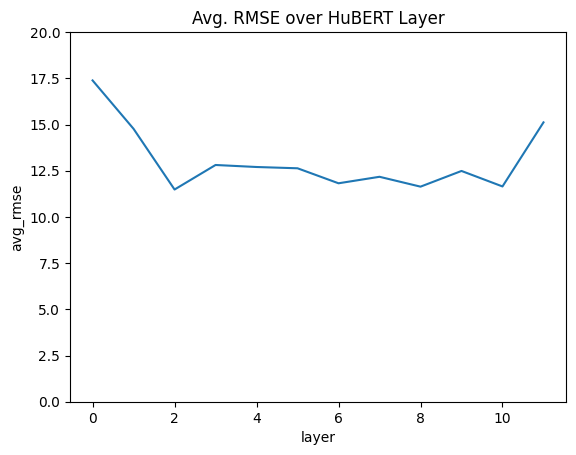

In [105]:
sns.lineplot(data=layer_err_df, x="layer", y="avg_rmse")
plt.ylim([0, 20])
plt.title("Avg. RMSE over HuBERT Layer")

## Congrats! We just did research